# Welcome!
## This is the date/time analysis only version. 


In [75]:
import numpy
import scipy
import matplotlib
import sklearn
import pandas as pd
import itertools
import gensim
import numpy as np
import seaborn

%matplotlib inline
import matplotlib.pyplot as plt # matplotlib plots
import matplotlib.gridspec as gridspec # for subplots

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

In [76]:
# Import some packages to help parse the dates
import time
import datetime as dt
import matplotlib.dates as mdates

In [77]:
df = pd.read_csv('Water_Quality_complaints.csv')
#census = pd.read_csv('New_York_City_Population_By_Boroughs.csv')

In [78]:
df.head(2)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,31503046,9/10/15,10/30/15,DEP,Department of Environmental Protection,Water Quality,Clear Water With Other Particles (Use Comments...,NaN,11213.0,1534 PROSPECT PLACE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.672986,-73.925914,"(40.6729859224145, -73.92591381590103)"
1,31539143,9/15/15,9/29/15,DEP,Department of Environmental Protection,Water Quality,Cloudy Or Milky Water (QB1),NaN,10025.0,840 COLUMBUS AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.796219,-73.965090,"(40.79621920145586, -73.96508964870316)"


In [79]:
df['Created Date'] = pd.to_datetime(df['Created Date'])

In [80]:
all_dates = df['Created Date'] # Get the date when each incident was created (reported)
all_dates[0:5]

0   2015-09-10
1   2015-09-15
2   2015-09-16
3   2015-09-16
4   2015-09-18
Name: Created Date, dtype: datetime64[ns]

## Think there may be a seasonal fluctuation to the complaints.  Can try decomposing using a python package that allows us to fit a model that accounts for seasonal fluctuation, overall trend, and noise.  
## (Thanks to AN6U5 on StackOverflow at http://stackoverflow.com/questions/20672236/time-series-decomposition-function-in-python)

In [81]:
# Generate a dataframe from the value counts of number of complaints on each day: 
dateCounts = pd.DataFrame(all_dates.value_counts().reset_index())
dateCounts.columns = ['dates','countsOnDate']
dateCounts.head()

# Thanks to MaxU at: 
# http://stackoverflow.com/questions/35809098/how-to-merge-pandas-value-counts-to-dataframe-or-use-it-to-subset-a-dataframe

,dates,countsOnDate
0,2013-04-29,41
1,2012-05-29,24
2,2012-09-24,18
3,2012-05-31,14
4,2012-11-23,13


In [82]:
# CloudyQB1_df = df[df['Descriptor'].str.contains('QB1')]
# dateCountsCloudyQB1 = CloudyQB1_df['Created Date'].value_counts().reset_index()
# dateCountsCloudyQB1.columns = ['dates','countsOnDate']
# dateCountsCloudyQB1.head()
dateCounts = df['Created Date'].value_counts().reset_index()
dateCounts.columns = ['dates','countsOnDate']
dateCounts.head()

,dates,countsOnDate
0,2013-04-29,41
1,2012-05-29,24
2,2012-09-24,18
3,2012-05-31,14
4,2012-11-23,13


In [106]:
# sortedDF = dateCountsCloudyQB1.sort_values('dates')
sortedDF = dateCounts.sort_values('dates')
print(max(sortedDF['countsOnDate']),min(sortedDF['countsOnDate']))
sortedDF[0:5]

41 1


,dates,countsOnDate
2285,2010-01-01,1
2087,2010-01-02,1
2144,2010-01-03,1
1821,2010-01-04,2
872,2010-01-05,4


In [84]:
# Try visualizing the counts vs time 
import pandas as pd
x = [pd.to_datetime(d) for d in sortedDF['dates']]
print(x[1:4])
# x = [d.month for d in x]
print(x[1:4])
y = sortedDF['countsOnDate']
x[0:5]

[Timestamp('2010-01-02 00:00:00'), Timestamp('2010-01-03 00:00:00'), Timestamp('2010-01-04 00:00:00')]
[Timestamp('2010-01-02 00:00:00'), Timestamp('2010-01-03 00:00:00'), Timestamp('2010-01-04 00:00:00')]


[Timestamp('2010-01-01 00:00:00'),
 Timestamp('2010-01-02 00:00:00'),
 Timestamp('2010-01-03 00:00:00'),
 Timestamp('2010-01-04 00:00:00'),
 Timestamp('2010-01-05 00:00:00')]

In [127]:
dateIdxSortedDF = sortedDF
dateIdxSortedDF = dateIdxSortedDF.set_index('dates');
dateIdxSortedDF.head()
print(dateIdxSortedDF['countsOnDate'].argmax())
max(dateIdxSortedDF['countsOnDate'])

2013-04-29 00:00:00


41

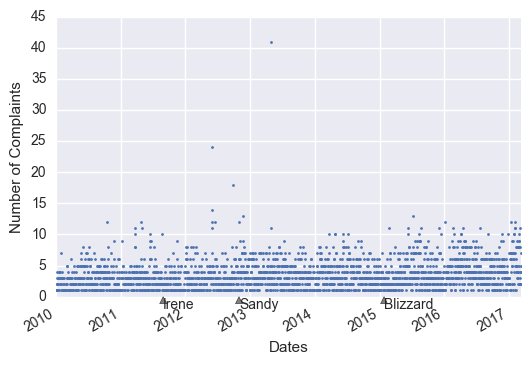

In [144]:
from dateutil.parser import parse
ax = dateIdxSortedDF.plot(linestyle='',marker='o', markersize=2,legend=False)
plt.xlabel('Dates')
plt.ylabel('Number of Complaints')

highlight_x = parse('8/28/2011')
highlight_y = 0 #sortedDF.ix[highlight_x]
an = ax.annotate('Irene', 
                 xy=(highlight_x, highlight_y), xytext=(highlight_x, highlight_y-2),
                 arrowprops={'facecolor':'grey', 'width':1, 'headwidth':5,'headlength':5},)


highlight_x = parse('10/29/2012')
highlight_y = 0 #sortedDF.ix[highlight_x]
an = ax.annotate('Sandy', 
                 xy=(highlight_x, highlight_y), xytext=(highlight_x, highlight_y-2),
                 arrowprops={'facecolor':'grey', 'width':1, 'headwidth':5,'headlength':5},)

highlight_x = parse('1/26/2015')
highlight_y = 0 #sortedDF.ix[highlight_x]
an = ax.annotate('Blizzard', 
                 xy=(highlight_x, highlight_y), xytext=(highlight_x, highlight_y-2),
                 arrowprops={'facecolor':'grey', 'width':1, 'headwidth':5,'headlength':5},)

plt.savefig('NumberOfComplaintsByDayAnnotated.png')

In [132]:
# plt.plot(x, y, linestyle='',marker='o', markersize=2)
# # plt.plot(x,yFilled, linestyle='',marker='o', markersize=2)
# # plt.ylim((0, 20))
# plt.xlabel('Dates')
# plt.ylabel('Number of Complaints')
# plt.savefig('NumberOfComplaintsByDay.png')

In [146]:
yDat = y[int((len(y)+1)/2):len(y)]
# yDat = y

guessMean = np.mean(yDat)
guessSD = np.std(yDat)
guessPhase = 0

tPts = np.linspace(0, 8*np.pi, len(yDat))
guessCos = guessSD*np.cos(tPts+guessPhase) 
guessCos = guessCos + guessMean # Function with initial parameters

# Tips from Dhara at http://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
from scipy.optimize import leastsq

optimize = lambda z: z[0]*np.cos(tPts+z[1]) + z[2] - yDat
estSD, estPhase, estMean = leastsq(optimize, [guessSD, guessPhase, guessMean])[0]

fitCos = estSD*np.cos(tPts+estPhase)
fitCos = fitCos + estMean # Function with optimized parameter estimates

fitCos[0:5]

array([ 4.38526522,  4.37899552,  4.37246995,  4.36569152,  4.35866336])

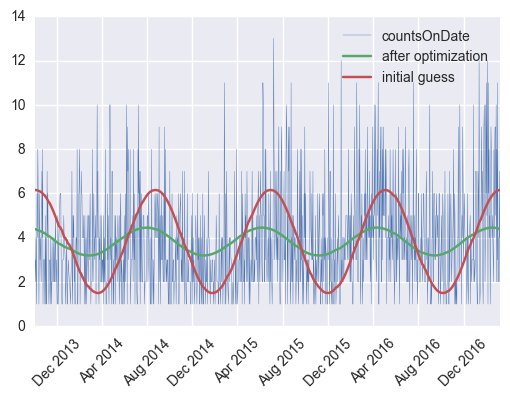

In [148]:
xDat = x[int((len(y)+1)/2):len(y)]
# xDat = x 

plt.plot(xDat,yDat,lw=.3)
plt.plot(xDat,fitCos, label = 'after optimization')
plt.plot(xDat,guessCos, label = 'initial guess')
plt.xticks(rotation=45)
plt.legend()
plt.savefig('FitCosine.png')

In [88]:
print(dateCounts['dates'][0:2])
sortedDF = dateCountsCloudyQB1.sort_values('dates')
sortedDF['dates'] = pd.to_datetime(dateCountsCloudyQB1['dates'])
sortedDF = sortedDF.set_index('dates')
print(sortedDF[0:5])

0   2013-04-29
1   2012-05-29
Name: dates, dtype: datetime64[ns]
            countsOnDate
dates                   
2010-01-05             1
2010-01-07             1
2010-01-12             1
2010-01-20             1
2010-01-25             1


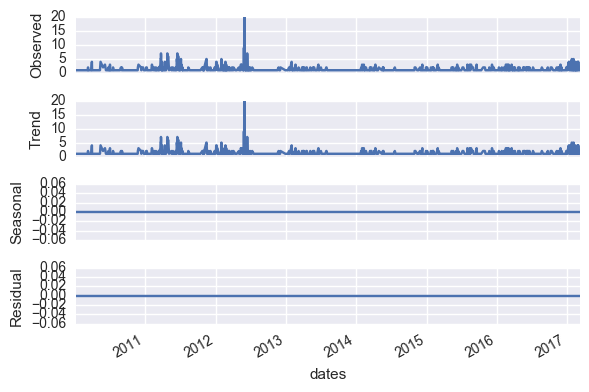

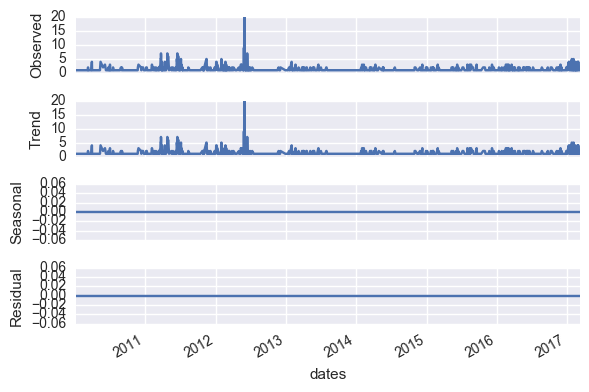

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(sortedDF, model='additive', freq=1)
result.plot()